In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import pairwise2
from Bio.Seq import Seq


### Query for the BLASTp search is the 'D' subunit from the `1MTY` pdb structure

In [ ]:
### The command for running blastp remotely
/home/kaustubh/miniconda3/bin/blastp -query query_MMO_seq.fasta -db nr -out MMO_blastp_output.csv -outfmt '10 qstart qend sstart send sacc ssciname stitle evalue qlen sseq' -evalue 0.00000001 -max_target_seqs 10000000 -remote

In [2]:
## There's an issue with the blastp output csv file; the title column has commas in it, which causes the csv to be read incorrectly.
### So this function readas the file linewise, and arrange accordingly

def custom_split(line):
    parts = line.strip().split(',')
    
    first_cols = parts[:6]    
    last_cols = parts[-3:]
    middle_col = [','.join(parts[6:-3])]
    
    return first_cols + middle_col + last_cols

In [3]:
with open("/mnt/researchdrive/Kaustubh/MMO/data/blast_search/MMO_blastp_output.csv", "r") as f:
    lines = f.readlines()

combined_lines = [custom_split(line) for line in lines]
column_names = ['qstart', 'qend', 'sstart', 'send', 'sacc', 'ssciname', 'stitle', 'evalue', 'qlen', 'sseq']

blastp_MMO_output = pd.DataFrame(combined_lines, columns=column_names)

## Remove the 'ssciname' column; since all entries are 'N/A'
blastp_MMO_output.drop(columns=['ssciname'], inplace=True)

## change the data types of the columns
blastp_MMO_output['qstart'] = blastp_MMO_output['qstart'].astype(int)
blastp_MMO_output['qend'] = blastp_MMO_output['qend'].astype(int)
blastp_MMO_output['sstart'] = blastp_MMO_output['sstart'].astype(int)
blastp_MMO_output['send'] = blastp_MMO_output['send'].astype(int)
blastp_MMO_output['evalue'] = blastp_MMO_output['evalue'].astype(float)
blastp_MMO_output['qlen'] = blastp_MMO_output['qlen'].astype(int)

blastp_MMO_output['q_aln_len'] = blastp_MMO_output['qend'] - blastp_MMO_output['qstart'] + 1
blastp_MMO_output['s_aln_len'] = blastp_MMO_output['send'] - blastp_MMO_output['sstart'] + 1

## I checked previously, the 's_aln_len' is same as len(sseq) after removing gaps, so directly replacing the gaps in the sseq entries
blastp_MMO_output['sseq'] = blastp_MMO_output['sseq'].apply(lambda x: x.strip().replace('-', ''))

blastp_MMO_output['log10_neg_evalue'] = blastp_MMO_output['evalue'].apply(lambda x: -np.log10(x) if x > 0 else 200)
blastp_MMO_output

,qstart,qend,sstart,send,sacc,stitle,evalue,qlen,sseq,q_aln_len,s_aln_len,log10_neg_evalue
0,1,527,1,527,WP_010960482,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000
1,1,527,1,527,WP_333689019,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000
2,1,527,1,527,1FYZ_A,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000
3,1,527,1,527,WP_198323378,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPASVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000
4,1,526,1,526,WP_266022270,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,526,526,200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
9370,46,387,37,374,WP_415070450,toluene monooxygenase [Hyphomicrobium sp.],0.000008,527,YGIGMEFWEEFDEPYKVTYRDYVQTQREKEVGAYSVKSATSRSEFY...,342,338,5.080922
9371,201,393,2,191,WP_325692884,"YHS domain-containing protein, partial [Mycoba...",0.000009,527,AIQLNFVFETGFTNLQFMAMAALADRAHHHLFEKTLASIQTDEARH...,193,190,5.037157
9372,57,383,22,343,MFZ9238208,phenol 2-monooxygenase [Burkholderiaceae bacte...,0.000009,527,QDPFKMTLDVWWRQQSEKDRRLYAVLDAFAQNNGQIGVSDARYVNA...,327,322,5.025488
9373,185,387,35,234,MFZ0874727,MmoB/DmpM family protein [Pseudonocardiaceae b...,0.000010,527,RATFDGMMMNPNVVDVAVQLPFTFETGFTNVQFVALSADALESGDI...,203,200,5.019542


In [4]:
# find the protein sequences that are identical
blastp_MMO_output['sseq'].unique()

array(['MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKYATKYKMANETKEQFKLIAKEYARMEAVKDERQFGSLQDALTRLNAGVRVHPKWNETMKVVSNFLEVGEYNAIAATGMLWDSAQAAEQKNGYLAQVLDEIRHTHQCAYVNYYFAKNGQDPAGHNDARRTRTIGPLWKGMKRVFSDGFISGDAVECSLNLQLVGEACFTNPLIVAVTEWAAANGDEITPTVFLSIETDELRHMANGYQTVVSIANDPASAKYLNTDLNNAFWTQQKYFTPVLGMLFEYGSKFKVEPWVKTWNRWVYEDWGGIWIGRLGKYGVESPRSLKDAKQDAYWAHHDLYLLAYALWPTGFFRLALPDQEEMEWFEANYPGWYDHYGKIYEEWRARGCEDPSSGFIPLMWFIENNHPIYIDRVSQVPFCPSLAKGASTLRVHEYNGQMHTFSDQWGERMWLAEPERYECQNIFEQYEGRELSEVIAELHGLRSDGKTLIAQPHVRGDKLWTLDDIKRLNCVFKNPVKAFN',
       'MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKYATKYKMANETKEQFKLIAKEYARMEAVKDERQFGSLQDALTRLNAGVRVHPKWNETMKVVSNFLEVGEYNAIAATGMLWDSAQAAEQKNGYLAQVLDEIRHTHQCAYVNYYFAKNGQDPAGHNDARRTRTIGPLWKGMKRVFSDGFISGDAVECSLNLQLVGEACFTNPLIVAVTEWAAANGDEITPTVFLSIETDELRHMANGYQTVVSIANDPAAAKYLNTDLNNAFWTQQKYFTPVLGMLFEYGSKFKVEPWVKTWNRWVYEDWGGIWIGRLGKYGVESPRSLKDAKQDAYWAHHDLYLLAYALWPTGFFRLALPDQEEMEWFEANYPGWYDHYGKIYEEWRARGCEDPSSGFIPLMWFIENNHPIYIDRVSQVPFCPSLAKGASTLRVHEYNGQMHTFSDQWGE

#### Looks like there are ~1000 sequences that are redundant, will need to remove these identical sequences

/tmp/ipykernel_673623/2415983232.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(blastp_MMO_output['log10_neg_evalue'], kde=True)


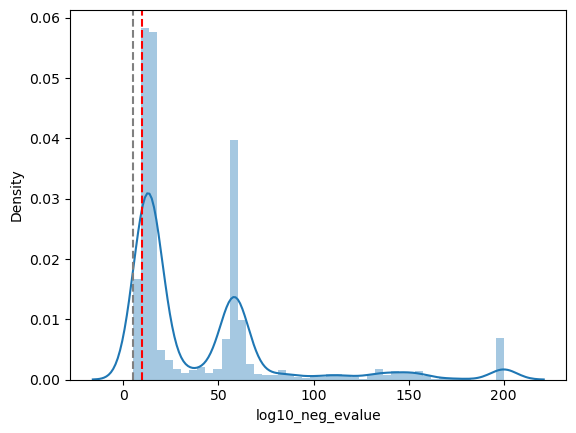

In [5]:
### E-value distribution

sns.distplot(blastp_MMO_output['log10_neg_evalue'], kde=True)
plt.axvline(x=5, color='gray', linestyle='--')
plt.axvline(x=10, color='red', linestyle='--')

Text(0.5, 1.0, 'Hit Sequence Length Distribution')

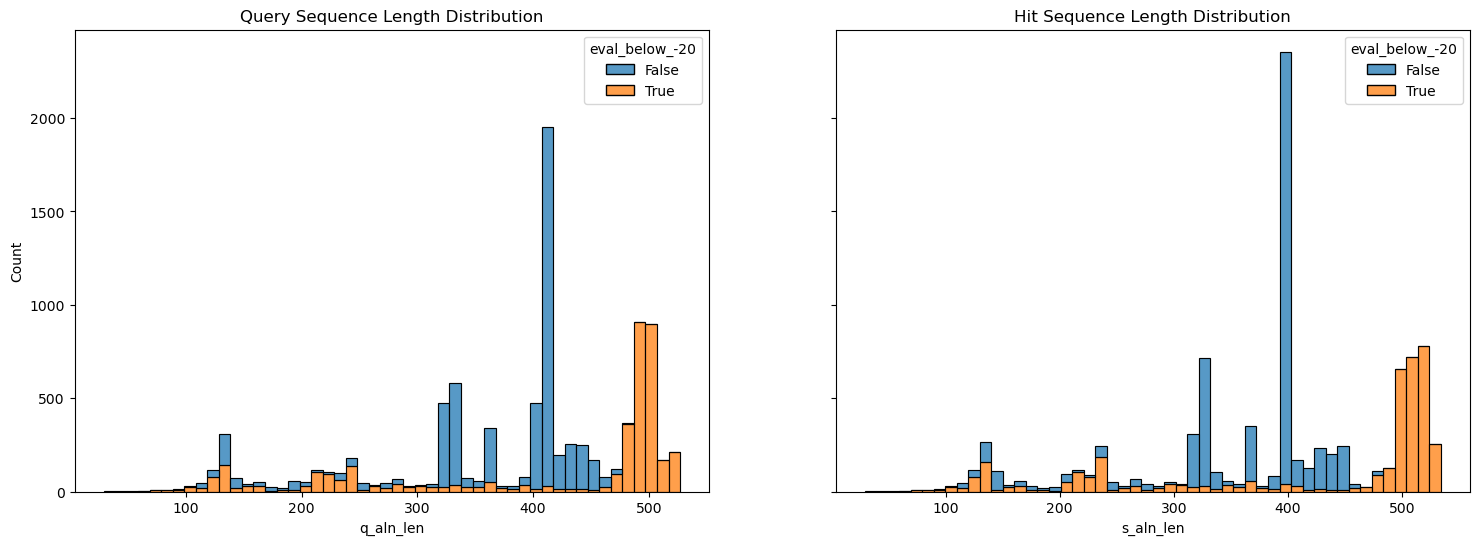

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

blastp_MMO_output['eval_below_-20'] = blastp_MMO_output['log10_neg_evalue'] > 20

sns.histplot(data=blastp_MMO_output, x='q_aln_len', hue='eval_below_-20', multiple="stack", bins=50, ax=ax[0])
sns.histplot(data=blastp_MMO_output, x='s_aln_len', hue='eval_below_-20', multiple="stack", bins=50, ax=ax[1])
ax[0].set_title('Query Sequence Length Distribution')
ax[1].set_title('Hit Sequence Length Distribution')

### There are a bunch of sequences (300-460 AAs) that are not that short but have comparatively lower e-values; These could be the potential homologs of interest!

## Combining the sequence titles and assigning them a recognizable name

In [7]:
## Get the unique titles of the sequences

### Remove the organisms info from title
blastp_MMO_output['stitle_wo_organism'] = blastp_MMO_output['stitle'].apply(lambda x: x.split(' [')[0])

unique_stitles = blastp_MMO_output['stitle'].unique()
unique_stitles_wo_organism = blastp_MMO_output['stitle_wo_organism'].unique()
print("len(unique_stitles):", len(unique_stitles), ";   len(unique_stitles_wo_organism):", len(unique_stitles_wo_organism))

unique_stitles_wo_organism

len(unique_stitles): 4385 ;   len(unique_stitles_wo_organism): 232


array(['MULTISPECIES: aromatic/alkene monooxygenase hydroxylase subunit alpha',
       'aromatic/alkene monooxygenase hydroxylase subunit alpha',
       'Chain A, METHANE MONOOXYGENASE COMPONENT A, ALPHA CHAIN',
       'aromatic/alkene/methane monooxygenase hydroxylase/oxygenase subunit alpha',
       'Chain D, METHANE MONOOXYGENASE HYDROLASE (ALPHA CHAIN)',
       'MAG: methane monooxygenase', 'methane monooxygenase',
       'soluble methane monooxygenase hydroxylase component alpha subunit',
       'soluble methane monooxygenase hydroxylase component alpha-subunit',
       'soluble methane monooxygenase protein A alpha subunit',
       'protein A alpha subunit of soluble methane monooxygenase',
       'Chain D, METHANE MONOOXYGENASE HYDROXYLASE',
       'Chain A, Methane monooxygenase component A alpha chain',
       'MmoX, partial', 'hypothetical protein',
       'soluble methane monooxygenase alpha subunit, partial',
       'soluble methane monooxygenase component a, partial',
    

In [8]:
## Assign the partial variable variable info on the pd df

## Check if the title contains 'partial' and assign it to a new column
blastp_MMO_output['partial'] = blastp_MMO_output['stitle_wo_organism'].apply(lambda x: 'partial' in x.lower())
blastp_MMO_output

,qstart,qend,sstart,send,sacc,stitle,evalue,qlen,sseq,q_aln_len,s_aln_len,log10_neg_evalue,eval_below_-20,stitle_wo_organism,partial
0,1,527,1,527,WP_010960482,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,MULTISPECIES: aromatic/alkene monooxygenase hy...,False
1,1,527,1,527,WP_333689019,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,aromatic/alkene monooxygenase hydroxylase subu...,False
2,1,527,1,527,1FYZ_A,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",False
3,1,527,1,527,WP_198323378,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPASVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,MULTISPECIES: aromatic/alkene monooxygenase hy...,False
4,1,526,1,526,WP_266022270,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,526,526,200.000000,True,aromatic/alkene monooxygenase hydroxylase subu...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,46,387,37,374,WP_415070450,toluene monooxygenase [Hyphomicrobium sp.],0.000008,527,YGIGMEFWEEFDEPYKVTYRDYVQTQREKEVGAYSVKSATSRSEFY...,342,338,5.080922,False,toluene monooxygenase,False
9371,201,393,2,191,WP_325692884,"YHS domain-containing protein, partial [Mycoba...",0.000009,527,AIQLNFVFETGFTNLQFMAMAALADRAHHHLFEKTLASIQTDEARH...,193,190,5.037157,False,"YHS domain-containing protein, partial",True
9372,57,383,22,343,MFZ9238208,phenol 2-monooxygenase [Burkholderiaceae bacte...,0.000009,527,QDPFKMTLDVWWRQQSEKDRRLYAVLDAFAQNNGQIGVSDARYVNA...,327,322,5.025488,False,phenol 2-monooxygenase,False
9373,185,387,35,234,MFZ0874727,MmoB/DmpM family protein [Pseudonocardiaceae b...,0.000010,527,RATFDGMMMNPNVVDVAVQLPFTFETGFTNVQFVALSADALESGDI...,203,200,5.019542,False,MmoB/DmpM family protein,False


In [9]:
Methane_monooxygenase = [
'Chain A, METHANE MONOOXYGENASE COMPONENT A, ALPHA CHAIN',
'aromatic/alkene/methane monooxygenase hydroxylase/oxygenase subunit alpha',
'Chain D, METHANE MONOOXYGENASE HYDROLASE (ALPHA CHAIN)',
'MAG: methane monooxygenase',
'methane monooxygenase',
'soluble methane monooxygenase hydroxylase component alpha subunit',
'soluble methane monooxygenase hydroxylase component alpha-subunit',
'soluble methane monooxygenase protein A alpha subunit',
'protein A alpha subunit of soluble methane monooxygenase',
'Chain D, METHANE MONOOXYGENASE HYDROXYLASE',
'Chain A, Methane monooxygenase component A alpha chain',
'MmoX, partial',
'soluble methane monooxygenase alpha subunit, partial',
'soluble methane monooxygenase component a, partial',
'soluble methane monooxygenase A-subunit, partial',
'soluble methane monooxygenase alpha subunit',
'MULTISPECIES: methane monooxygenase',
'soluble methane monooxygenase protein A, partial',
'soluble methane monooxygenase, partial',
'soluble methane monooxygenase component A alpha subunit, partial',
'MAG: methane monooxygenase, partial',
'soluble methane monooxygenase alpha, subunit, partial',
'soluble methane monooxygenase, alpha subunit, partial',
'methane monooxygenase component A alpha chain',
'soluble methane monooxygenase hydroxylase, partial',
'soluble methane monooxygenase component A alpha subunit',
'methane monooxygenase, partial',
'soluble methane monooxygenase active site subunit, partial',
'soluble methane monooxygenase alpha-subunit, partial',
'soluble methane monooxygenase subunit A, partial',
'soluble methane mooxygenase alpha subunit, partial',
'Mmox, partial',
'soluble methane monooxygenase A-protein alpha-subunit, partial',
'MULTISPECIES: aromatic/alkene/methane monooxygenase hydroxylase/oxygenase subunit alpha',
'Methane monooxygenase component A alpha chain',
'soluble methane monooxygenase protein A large subunit, partial',
'methane monooxygenase component A alpha subunit, partial',
'methane oxidase, partial',
'Methane monooxygenase component alpha chain',
'Methane monooxygenase',
'methane monooxygenase subunit A alpha, partial',
'souble methane monooxygenase, partial',
'MAG: Methane monooxygenase component A alpha chain',
'MAG: aromatic/alkene/methane monooxygenase hydroxylase/oxygenase subunit alpha',
'soluble methane monooxygenase A alpha chain, partial',
'methane/phenol/toluene hydroxylase subunit alpha',
'putative methane/phenol/toluene monooxygenase subunit, Alpha chain',
'[similarity to] soluble methane monooxygenase hydroxylase component alpha-subunit',
'methane monooxygenase component A alpha chain, partial',
'aromatic/alkene/methane monooxygenase hydroxylase/oxygenase subunit alpha, partial',
'methane/phenol/toluene monooxygenase alpha subunit',
'mmoX',
'MULTISPECIES: aromatic/alkene/methane monooxygenase hydroxylase/oxygenase subunit alpha, partial',
'Methane monooxygenase component A alpha chain EC 1141325 CDS',
'MAG: Methane monooxygenase component A alpha chain, partial',
'methane monooxygenase alpha subunit, partial'
]

Propane_monooxygenase = [
'propane monooxygenase hydroxylase large subunit',
'propane 2-monooxygenase large subunit',
'propane monooxygenase large subunit',
'propane monooxygenase hydroxylase alpha subunit',
'MAG: propane monooxygenase large subunit PrmA',
'putative phenol and propane monooxygenase large subunit',
'propane monooxygenase hydroxylase large subunit, partial',
'propane monooxygenase large subunit, partial',
'Propane monooxygenase large subunit',
'Propane 2-monooxygenase, hydroxylase component large subunit',
'propane monooxygenase, partial',
'apropane monooxygenase, partial'
]

Toluene_monooxygenase = [
'phenol/toluene 2-monooxygenase',
'toluene monooxygenase',
'toluene ortho-monooxygenase subunit',
'Toluene-4-monooxygenase, subunit TmoA',
'Toluene-4-monooxygenase system protein A',
'toluene-4-monooxygenase system B family protein',
'MAG: toluene monooxygenase',
'toluene monooxygenase system protein',
'toluene 4-monooxygenase protein A',
'toluene monooxygenase system protein A',
'toluene 4-monooxygenase protein',
'toluene-4-monooxygenase system, hydroxylase component subunit alpha',
'phenol/toluene 2-monooxygenase (NADH) P3/A3',
'MULTISPECIES: Toluene-4-monooxygenase system protein A',
'methane/phenol/toluene monooxygenase',
'Toluene-4-monooxygenase system, hydroxylase component subunit alpha',
'MAG: toluene monooxygenase system protein A',
'MULTISPECIES: toluene monooxygenase',
'toluene o-xylene monooxygenase component',
'Chain A, Toluene, o-xylene monooxygenase oxygenase subunit',
'toluene-4-monooxygenase subunit TmoA',
'MAG: toluene monooxygenase, partial',
'Chain A, Toluene o-xylene monooxygenase component',
'toluene monooxygenase, partial',
'Chain A, Toluene, o-xylene monooxygenase oxygenase subunit;alpha',
'Toluene-4-monooxygenase system protein',
'toluene-4-monooxygenase system protein A',
'toluene-4-monooxygenase system hydroxylase subunit alpha TmoA',
'Chain A, Toluene-4-monooxygenase system protein A',
'MAG: Toluene-4-monooxygenase system protein A',
'toluene-4-monooxygenase',
'toluene-3-monooxygenase oxygenase subunit 1',
'MULTISPECIES: toluene-4-monooxygenase system hydroxylase subunit alpha TmoA',
'Methane/phenol/toluene hydroxylase',
'MAG: toluene monooxygenase system protein A, partial'
]

Other_monooxygenase = [
'MULTISPECIES: aromatic/alkene monooxygenase hydroxylase subunit alpha',
'aromatic/alkene monooxygenase hydroxylase subunit alpha',
'butane monooxygenase hydroxylase BMOH alpha subunit',
'butane monooxygenase alpha subunit',
'putative butane monooxygenase alpha subunit, partial',
'monooxygenase',
'monooxygenase hydroxylase, subunit',
'class 6 soluble di-iron monooxygenase alpha subunit',
'MAG: monooxygenase',
'monooxygenase, partial',
'alkene monooxygenase alpha subunit',
'putative soluble di-iron monooxygenase alpha subunit',
'MULTISPECIES: monooxygenase hydroxylase, subunit A',
'soluble di-iron monooxygenase alpha subunit, partial',
'alkene monooxygenase alpha-subunit',
'ethene monooxygenase alpha subunit',
'putative alkene monooxygenase alpha subunit',
'Soluble di-iron monooxygenase alpha subunit',
'soluble di-iron monooxygenase alpha subunit',
'alpha-subunit of multicomponent tetrahydrofuran monooxygenase',
'tetrahydrofuran monooxygenase oxygenase component alpha subunit',
'putative monooxygenase alpha subunit',
'multicomponent tetrahydrofuran-degrading monooxygenase alhpa-subnit',
'alkene monooxygenase alpha subunit, partial',
'soluble Di-iron monooxygenase alpha subunit, partial',
'multicomponent tetrahydrofuran-degrading monooxygenase alhpa-subunit, partial',
'phenol 2-monooxygenase',
'MAG: phenol 2-monooxygenase',
'multicomponent tetrahydrofuran-degrading monooxygenase alpha-subnit, partial',
'soluble di-iron monooxygenase, partial',
'phenol 2-monooxygenase, partial',
'phenol 2-monooxygenase subunit',
'MAG: phenol 2-monooxygenase P3 subunit',
'isoprene monooxygenase oxygenase subunit alpha',
'Alkene monooxygenase system, oxygenase component subunit alpha',
'Tbc1D monooxygenase',
'MAG: phenol 2-monooxygenase, partial',
'MULTISPECIES: isoprene monooxygenase oxygenase subunit alpha',
'tetrahydrofuran monooxygenase, partial',
'MAG: isoprene monooxygenase oxygenase subunit alpha, partial',
'isoprene monooxygenase hydroxylase alpha subunit, partial',
'RecName: Full=Alkene monooxygenase system, oxygenase component subunit alpha',
'benzene monooxygenase oxygenase subunit',
'phenol 2-monooxygenase oxygenase component DmpN',
'MULTISPECIES: phenol 2-monooxygenase oxygenase component DmpN',
'Tbc2A monooxygenase',
'phenol 2-monooxygenase P3 subunit',
'phenol 2-monooxygenase oxygenase component DmpN, partial',
'putative alkene monooxygenase alpha subunit, partial',
'MULTISPECIES: phenol 2-monooxygenase',
'putative monooxygenase large subunit A, partial',
'soluble diiron monooxygenase, partial'
]

hypothetical_proteins = [
'hypothetical protein',
'hypothetical protein NpR2053_10190',
'hypothetical protein ACQPW4_26220',
'hypothetical protein, partial',
'MULTISPECIES: hypothetical protein',
'hypothetical protein ACQP2A_17340',
'hypothetical protein ACQPZV_25600',
'hypothetical protein NpR2053_10180',
'hypothetical protein BDC11040_39260',
'hypothetical protein BRDID11002_11430',
'hypothetical protein BRDID11015_30610',
'hypothetical protein GCM10027597_59960',
'hypothetical protein MOKP106_40350',
'MAG: hypothetical protein FD131_934',
'hypothetical protein BRDID11015_30620',
'MAG: hypothetical protein E6J03_05350',
'hypothetical protein N801_04700, partial'
]

Different_hydroxylases = [
'hydroxylase alpha subunit, partial',
'alpha hydroxylase',
'hydroxylase component subunit alpha, partial',
'toluene hydroxylase',
'methane/phenol/toluene hydroxylase',
'phenol hydroxylase P3 protein',
'phenolhydroxylase component',
'phenol hydroxylase component 3',
'phenol hydroxylase, partial',
'phenol hydroxylase oxygenase component',
'phenol hydroxylase oxygenase component alfa oxygenase subunit',
'phenol hydroxylase subunit',
'MAG: phenol hydroxylase oxygenase subuit',
'Chain A, Phenol hydroxylase component phN',
'MULTISPECIES: methane/phenol/toluene hydroxylase',
'Methane/phenol/toluene hydroxylase:YHS',
'phenol hydroxylase alpha subunit, partial',
'Phenol hydroxylase, P3 oxygenase component DmpN',
'MAG: Phenol hydroxylase, P3 oxygenase component DmpN',
'phenol hydroxylase component',
'phenol hydroxylase component phN',
'methane/phenol/toluene hydroxylase:YHS',
'subunit of phenolhydroxylase',
'phenol hydroxylase',
'hydroxylase subunit 4',
'phenol hydroxylase P3 protein, partial',
'methane/phenol/toluene hydroxylase, partial',
'phenol hydroyxlase large-subunit, partial',
'multi-component phenol hydoxylase subunit alpha LapN'
]

YHS_domain_protein = [
'YHS domain-containing protein',
'MULTISPECIES: YHS domain-containing protein',
'MAG: YHS domain-containing protein',
'YHS domain-containing protein, partial',
'MAG: YHS domain-containing protein, partial'
]

Other = [
'PmoC',
'SDIMOs-alpha subunit',
'2Fe-2S iron-sulfur cluster-binding protein',
'unnamed protein product, partial',
'TCP-1/cpn60 chaperonin family protein',
'PmlD',
'MEDS domain-containing protein',
'MAG: lapN',
'MphN',
'phenol hydrolase subunit alpha',
'dimethylsulfoxide oxygenase delta subunit',
'DMS oxygenase component',
'HpdC',
'BtxD',
'tmoA',
'catechol dioxygenase',
'TomA3',
'DmpN',
'BtxP',
'PheN',
'alpha subunit-terminal oygenase component',
'ComEC/Rec2 family competence protein',
'MmoB/DmpM family protein',
'B100',
'H47'
]

In [10]:
major_group_names_ids = ["Methane_monooxygenase", "Propane_monooxygenase", "Toluene_monooxygenase", "Other_monooxygenase", "hypothetical_proteins", "Different_hydroxylases", "YHS_domain_protein", "Other"]
major_group_names = [Methane_monooxygenase, Propane_monooxygenase, Toluene_monooxygenase, Other_monooxygenase, hypothetical_proteins, Different_hydroxylases, YHS_domain_protein, Other]
major_group_dict = {}

for i in range(len(major_group_names)):
    for j in major_group_names[i]:
        major_group_dict[j] = major_group_names_ids[i]

blastp_MMO_output['major_group'] = blastp_MMO_output['stitle_wo_organism'].map(major_group_dict)
blastp_MMO_output

,qstart,qend,sstart,send,sacc,stitle,evalue,qlen,sseq,q_aln_len,s_aln_len,log10_neg_evalue,eval_below_-20,stitle_wo_organism,partial,major_group
0,1,527,1,527,WP_010960482,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,MULTISPECIES: aromatic/alkene monooxygenase hy...,False,Other_monooxygenase
1,1,527,1,527,WP_333689019,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,aromatic/alkene monooxygenase hydroxylase subu...,False,Other_monooxygenase
2,1,527,1,527,1FYZ_A,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",False,Methane_monooxygenase
3,1,527,1,527,WP_198323378,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPASVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,MULTISPECIES: aromatic/alkene monooxygenase hy...,False,Other_monooxygenase
4,1,526,1,526,WP_266022270,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,526,526,200.000000,True,aromatic/alkene monooxygenase hydroxylase subu...,False,Other_monooxygenase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,46,387,37,374,WP_415070450,toluene monooxygenase [Hyphomicrobium sp.],0.000008,527,YGIGMEFWEEFDEPYKVTYRDYVQTQREKEVGAYSVKSATSRSEFY...,342,338,5.080922,False,toluene monooxygenase,False,Toluene_monooxygenase
9371,201,393,2,191,WP_325692884,"YHS domain-containing protein, partial [Mycoba...",0.000009,527,AIQLNFVFETGFTNLQFMAMAALADRAHHHLFEKTLASIQTDEARH...,193,190,5.037157,False,"YHS domain-containing protein, partial",True,YHS_domain_protein
9372,57,383,22,343,MFZ9238208,phenol 2-monooxygenase [Burkholderiaceae bacte...,0.000009,527,QDPFKMTLDVWWRQQSEKDRRLYAVLDAFAQNNGQIGVSDARYVNA...,327,322,5.025488,False,phenol 2-monooxygenase,False,Other_monooxygenase
9373,185,387,35,234,MFZ0874727,MmoB/DmpM family protein [Pseudonocardiaceae b...,0.000010,527,RATFDGMMMNPNVVDVAVQLPFTFETGFTNVQFVALSADALESGDI...,203,200,5.019542,False,MmoB/DmpM family protein,False,Other


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Other_monooxygenase'),
  Text(1, 0, 'Methane_monooxygenase'),
  Text(2, 0, 'hypothetical_proteins'),
  Text(3, 0, 'Different_hydroxylases'),
  Text(4, 0, 'YHS_domain_protein'),
  Text(5, 0, 'Propane_monooxygenase'),
  Text(6, 0, 'Other'),
  Text(7, 0, 'Toluene_monooxygenase')])

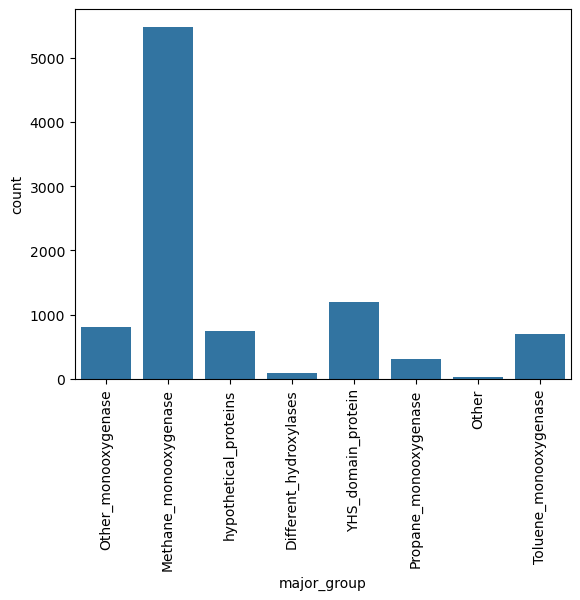

In [11]:
sns.countplot(data=blastp_MMO_output, x='major_group')
plt.xticks(rotation=90)

### Deleting the hypothetical proteins

In [12]:
blastp_MMO_output = blastp_MMO_output[blastp_MMO_output['major_group'] != 'hypothetical_proteins']
blastp_MMO_output

,qstart,qend,sstart,send,sacc,stitle,evalue,qlen,sseq,q_aln_len,s_aln_len,log10_neg_evalue,eval_below_-20,stitle_wo_organism,partial,major_group
0,1,527,1,527,WP_010960482,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,MULTISPECIES: aromatic/alkene monooxygenase hy...,False,Other_monooxygenase
1,1,527,1,527,WP_333689019,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,aromatic/alkene monooxygenase hydroxylase subu...,False,Other_monooxygenase
2,1,527,1,527,1FYZ_A,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,"Chain A, METHANE MONOOXYGENASE COMPONENT A, AL...",False,Methane_monooxygenase
3,1,527,1,527,WP_198323378,MULTISPECIES: aromatic/alkene monooxygenase hy...,0.000000,527,MALSTATKAATDALAANRAPASVNAQEVHRWLQSFNWDFKNNRTKY...,527,527,200.000000,True,MULTISPECIES: aromatic/alkene monooxygenase hy...,False,Other_monooxygenase
4,1,526,1,526,WP_266022270,aromatic/alkene monooxygenase hydroxylase subu...,0.000000,527,MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKY...,526,526,200.000000,True,aromatic/alkene monooxygenase hydroxylase subu...,False,Other_monooxygenase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,46,387,37,374,WP_415070450,toluene monooxygenase [Hyphomicrobium sp.],0.000008,527,YGIGMEFWEEFDEPYKVTYRDYVQTQREKEVGAYSVKSATSRSEFY...,342,338,5.080922,False,toluene monooxygenase,False,Toluene_monooxygenase
9371,201,393,2,191,WP_325692884,"YHS domain-containing protein, partial [Mycoba...",0.000009,527,AIQLNFVFETGFTNLQFMAMAALADRAHHHLFEKTLASIQTDEARH...,193,190,5.037157,False,"YHS domain-containing protein, partial",True,YHS_domain_protein
9372,57,383,22,343,MFZ9238208,phenol 2-monooxygenase [Burkholderiaceae bacte...,0.000009,527,QDPFKMTLDVWWRQQSEKDRRLYAVLDAFAQNNGQIGVSDARYVNA...,327,322,5.025488,False,phenol 2-monooxygenase,False,Other_monooxygenase
9373,185,387,35,234,MFZ0874727,MmoB/DmpM family protein [Pseudonocardiaceae b...,0.000010,527,RATFDGMMMNPNVVDVAVQLPFTFETGFTNVQFVALSADALESGDI...,203,200,5.019542,False,MmoB/DmpM family protein,False,Other


In [17]:
query_1mty_seq = "MALSTATKAATDALAANRAPTSVNAQEVHRWLQSFNWDFKNNRTKYATKYKMANETKEQFKLIAKEYARMEAVKDERQFGSLQDALTRLNAGVRVHPKWNETMKVVSNFLEVGEYNAIAATGMLWDSAQAAEQKNGYLAQVLDEIRHTHQCAYVNYYFAKNGQDPAGHNDARRTRTIGPLWKGMKRVFSDGFISGDAVECSLNLQLVGEACFTNPLIVAVTEWAAANGDEITPTVFLSIETDELRHMANGYQTVVSIANDPASAKYLNTDLNNAFWTQQKYFTPVLGMLFEYGSKFKVEPWVKTWNRWVYEDWGGIWIGRLGKYGVESPRSLKDAKQDAYWAHHDLYLLAYALWPTGFFRLALPDQEEMEWFEANYPGWYDHYGKIYEEWRARGCEDPSSGFIPLMWFIENNHPIYIDRVSQVPFCPSLAKGASTLRVHEYNGQMHTFSDQWGERMWLAEPERYECQNIFEQYEGRELSEVIAELHGLRSDGKTLIAQPHVRGDKLWTLDDIKRLNCVFKNPVKAFN"

In [20]:
seq_id_wrt_query = []

def compute_pairwise_identity(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)
    if not alignments:
        return 0.0
    alignment = alignments[0]
    matches = sum(c1 == c2 for c1, c2 in zip(alignment.seqA, alignment.seqB))
    identity = matches / max(len(seq1), len(seq2))
    return identity

for idx, row in blastp_MMO_output.iterrows():
    seq = row['sseq']
    identity = compute_pairwise_identity(seq, query_1mty_seq)
    seq_id_wrt_query.append(identity)

blastp_MMO_output['identity_wrt_query'] = seq_id_wrt_query

/tmp/ipykernel_673623/2155280581.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blastp_MMO_output['identity_wrt_query'] = seq_id_wrt_query


<Axes: xlabel='identity_wrt_query', ylabel='Count'>

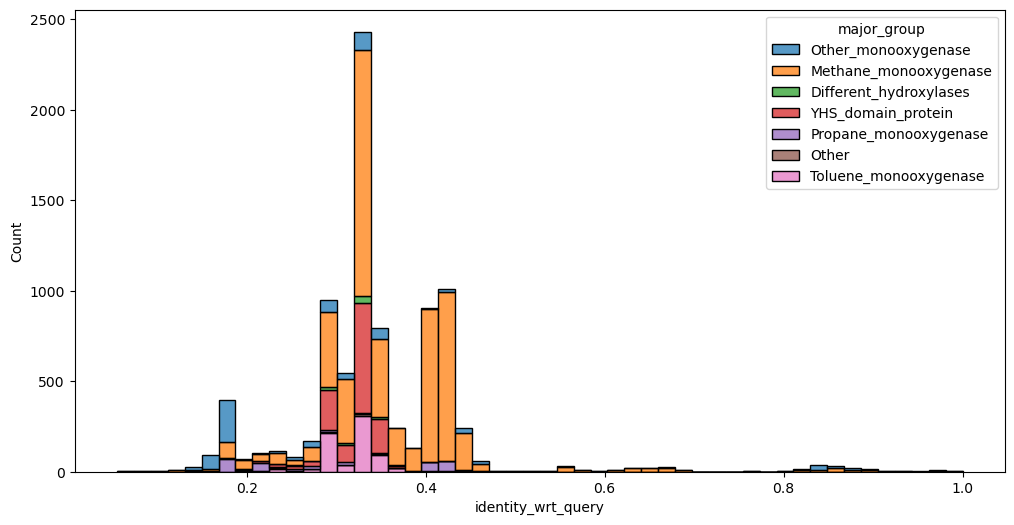

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(data=blastp_MMO_output, x='identity_wrt_query', hue="major_group", multiple="stack", bins=50)

### Write the sequences from pd df to a fasta file

Aims: Remove redundant sequences -- perform clustering based on identity